In [0]:
from fastai.vision import *

In [0]:
%%capture

!unzip "/content/drive/My Drive/lenses.zip"

In [0]:
path = Path('/content/lenses') # Define path to the image folders

data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.1,
                                  ds_tfms=get_transforms(do_flip=True, 
                                                         flip_vert=True, 
                                                         max_rotate=90.0, 
                                                         p_affine=0.05, 
                                                         p_lighting=0.05), 
                                  size=(64,64),
                                  resize_method=ResizeMethod.SQUISH,
                                  num_workers=4, 
                                  bs = 128) \
                                .normalize(imagenet_stats)

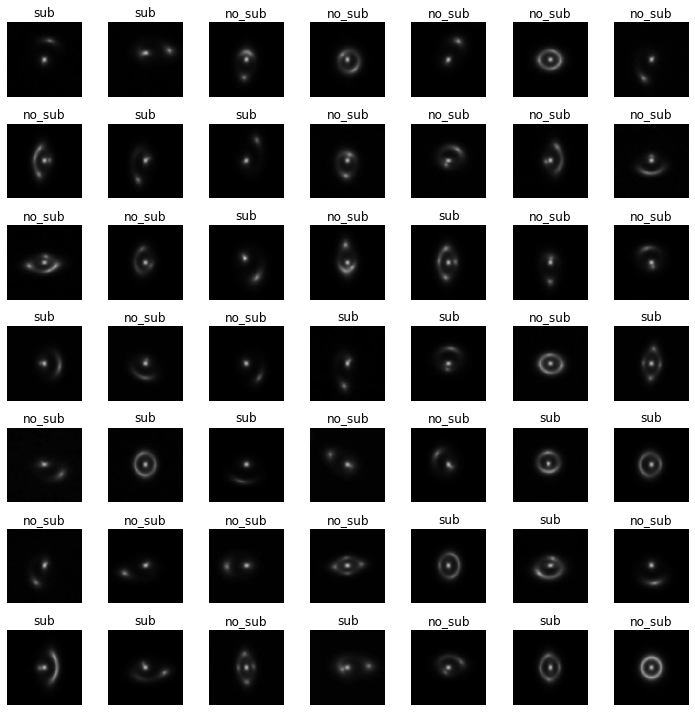

In [4]:
data.show_batch(rows=7, figsize=(10, 10))

In [5]:
learn = cnn_learner(data, 
                     models.resnet50,       
                     metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [6]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.120584,0.753834,0.623000,00:32
1,0.991821,0.589901,0.691000,00:26
2,0.899350,0.618546,0.703000,00:26
3,0.811748,0.574947,0.708000,00:26
4,0.732546,0.522598,0.724000,00:27
5,0.646652,0.499635,0.739000,00:27
6,0.596870,0.483929,0.750000,00:27
7,0.557136,0.463708,0.770000,00:27
8,0.527313,0.447606,0.759000,00:27
9,0.499528,0.390582,0.808000,00:27


In [0]:
learn.export()

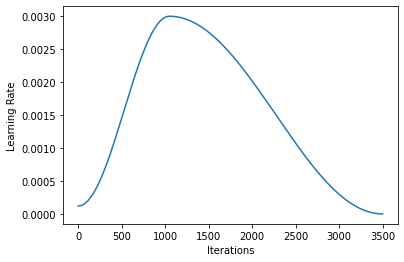

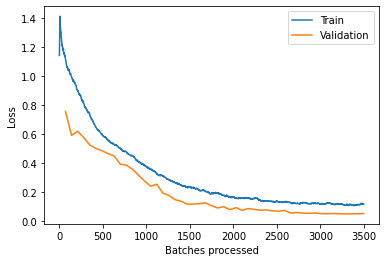

In [8]:
learn.recorder.plot_lr()
learn.recorder.plot_losses()

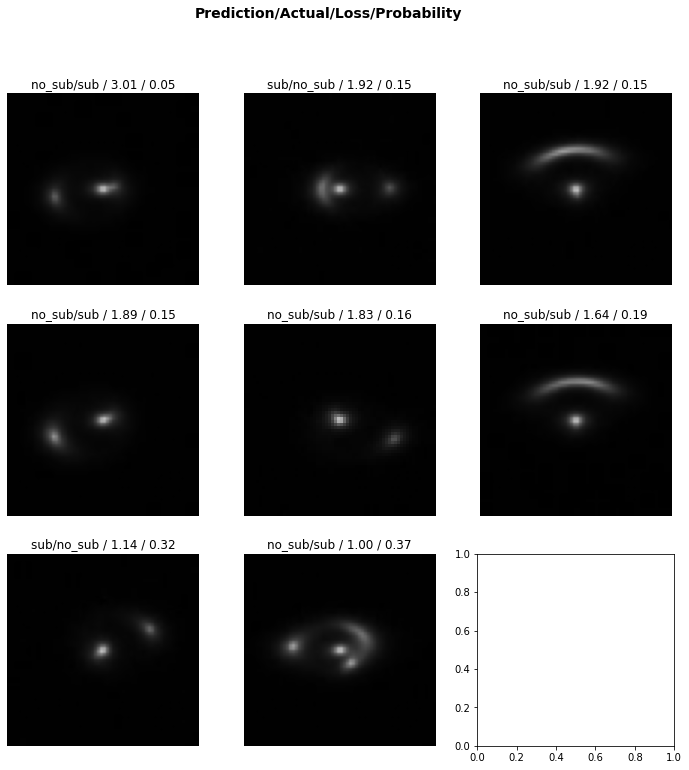

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(8,heatmap=True)

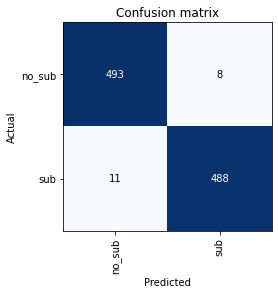

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
learn.save('version_1')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


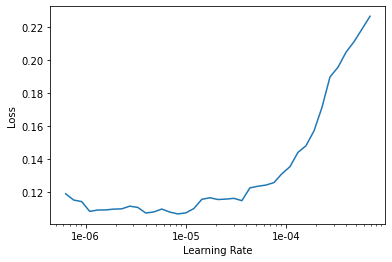

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, slice(1e-5,1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.125031,0.074705,0.971000,00:30
1,0.127781,0.052801,0.984000,00:30
2,0.122464,0.058638,0.979000,00:30
3,0.114676,0.048893,0.983000,00:30
4,0.102558,0.048343,0.980000,00:31


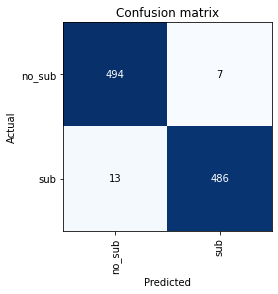

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [21]:
learn.load('version_1')

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
sub,sub,sub,sub,sub
Path: /content/lenses;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
sub,no_sub,no_sub,no_sub,no_sub
Path: /content/lenses;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): C

In [24]:
# %%capture

preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)

In [25]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)

print('The accuracy is {0} %.'.format(acc))
print('ROC area is {0}'.format(roc_auc))

The accuracy is 0.9810000061988831 %.
ROC area is 0.9989119956479826


No handles with labels found to put in legend.


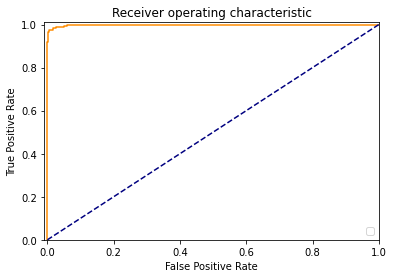

In [27]:
plt.figure()

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

In [0]:
learner = load_learner("/content/lenses", test=ImageList.from_folder("/content/lenses"))

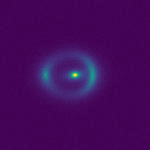

In [44]:
il = ImageList.from_folder("/content/lenses")
il.convert_mode = 'L'
il.open(il.items[1006])

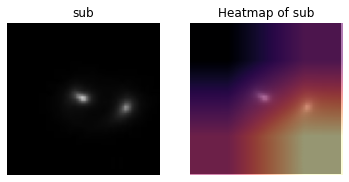

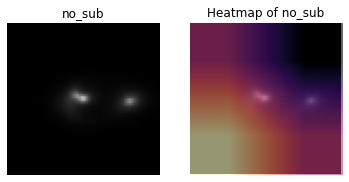

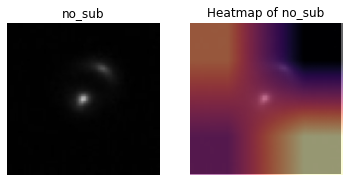

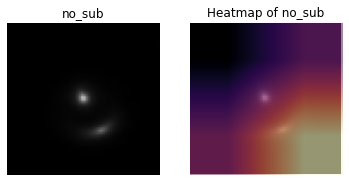

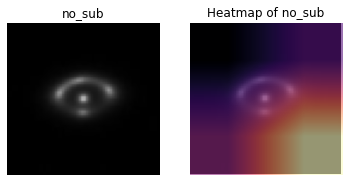

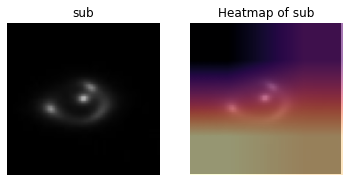

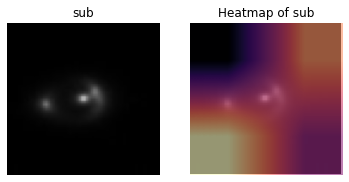

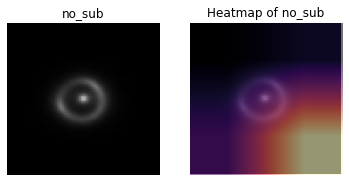

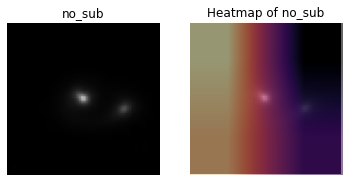

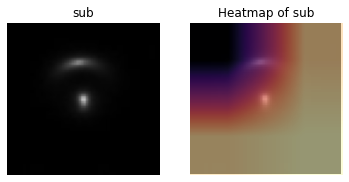

In [37]:
from fastai.callbacks.hooks import *

def visualize_cnn_by_heatmap(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'Heatmap of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(10):
    visualize_cnn_by_heatmap(learn, idx)

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Mar 16 16:03:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  75W |   2191MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  